Loading training dataset...
Training dataset loaded.
Iteration 1, loss = 0.14099625
Validation score: 0.435571
Iteration 2, loss = 0.11578885
Validation score: 0.441790
Iteration 3, loss = 0.11599085
Validation score: 0.420929
Iteration 4, loss = 0.11603567
Validation score: 0.445212
Iteration 5, loss = 0.11522618
Validation score: 0.442729
Iteration 6, loss = 0.11019231
Validation score: 0.487634
Iteration 7, loss = 0.10474724
Validation score: 0.518156
Iteration 8, loss = 0.09579780
Validation score: 0.574133
Iteration 9, loss = 0.08107443
Validation score: 0.665648
Iteration 10, loss = 0.06508917
Validation score: 0.720337
Iteration 11, loss = 0.05502828
Validation score: 0.760178
Iteration 12, loss = 0.04860543
Validation score: 0.787707
Iteration 13, loss = 0.04644107
Validation score: 0.806922
Iteration 14, loss = 0.04415363
Validation score: 0.796968
Iteration 15, loss = 0.04317602
Validation score: 0.813963
Iteration 16, loss = 0.04296255
Validation score: 0.809067
Iteration 17

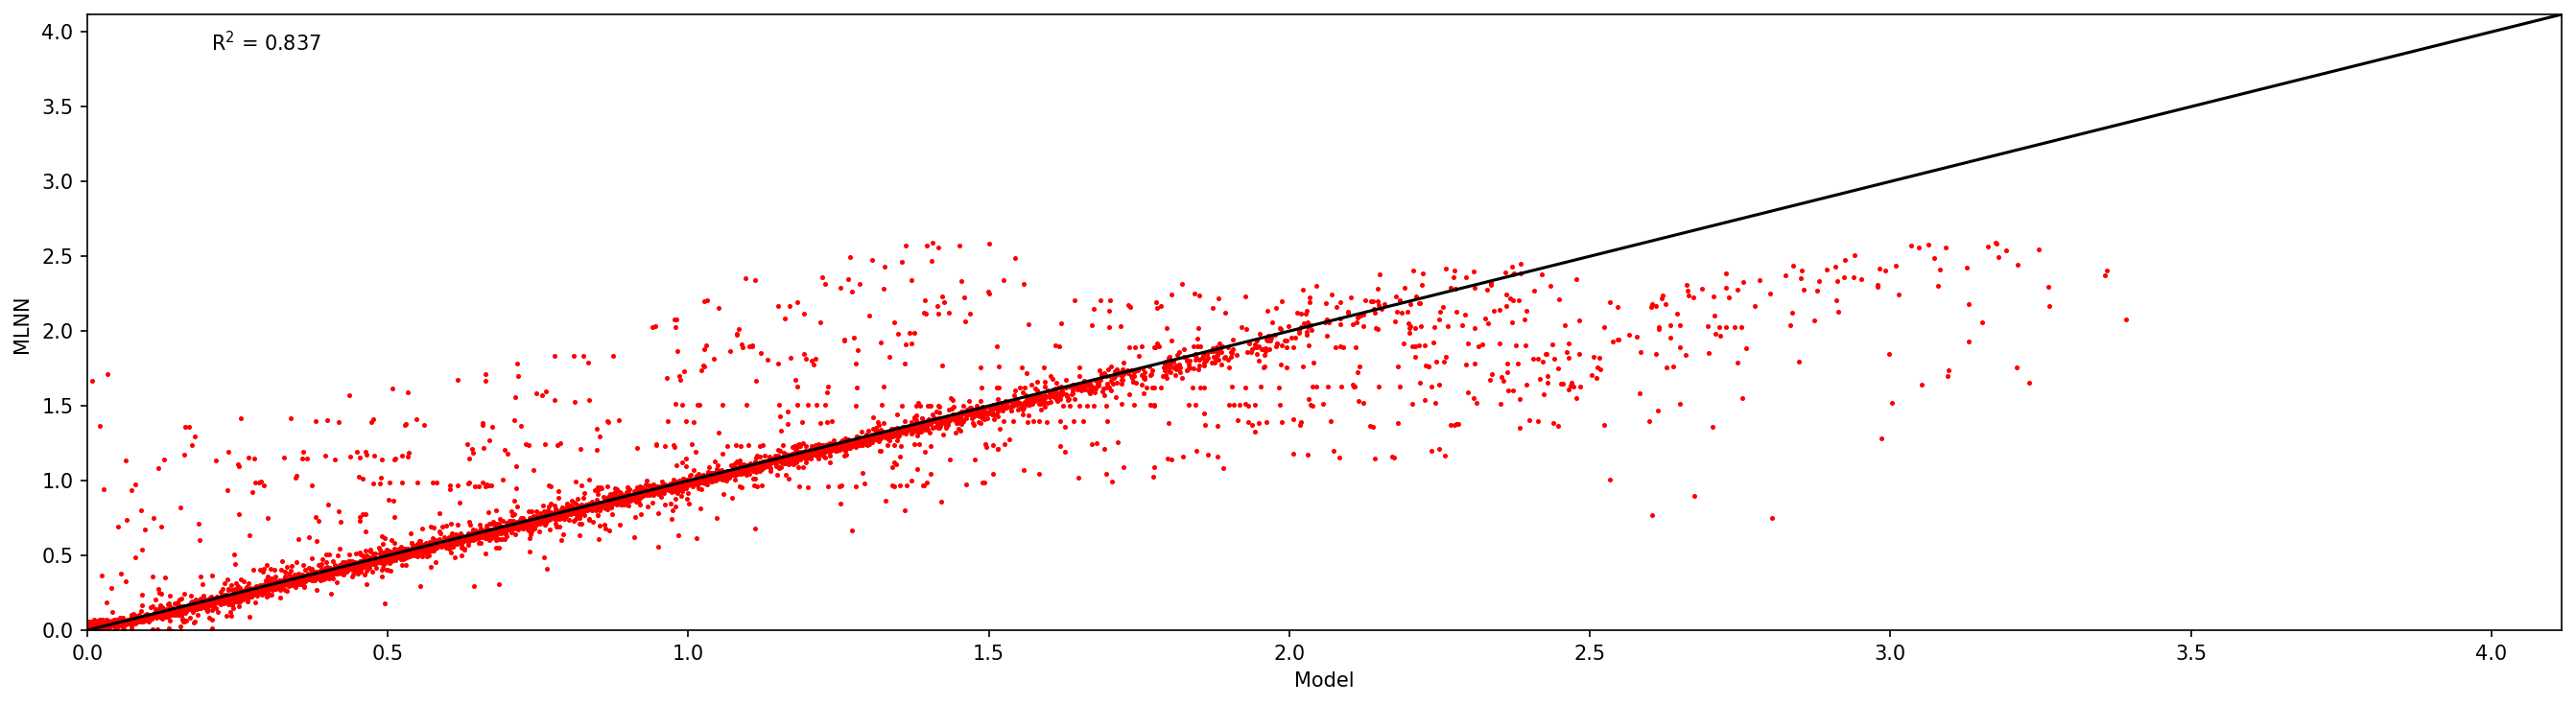

In [1]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

# add accuracy line for the code.

import numpy as np
import random
import math
import h5py
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# disable FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

train_data_path='./training_Data/'
output_path='./net/'

nnstr='Aerosol' #NN name string
hiddenlayers=(100, 90, 75) #set MLNN hidden layers (hidden layers will be reset for aaNN based on number of bands)


# Add more layers , 50, 40, 10, 1

#radoption=2 #TOA rad data type, options: 1=Lt, 2=Lrc 
addnoise=1 #Flag for adding Gaussian noise NOTE: do not add noise for forward training
noiselevel=0.05 #Gaussian noise level, e.g. 1=1%

#sensor band infos
band=[302,312,320,340,380]
trainband=np.arange(5)
nrrs=5
aodidx=np.arange(5)

#number of sample in the scatter plot, if total number of data points is less than this, half of the data will be used for plotting
nplotsample=5000 
	
nband=len(band)
ntrainband=len(trainband)
naod=len(aodidx) 
      
#read in training data
print('Loading training dataset...')

for i in np.arange(5):
    if i==0:       
       par=np.loadtxt(train_data_path +'ML-input'+str(i+1)+'.txt')
    else:
       par=np.append(par,np.loadtxt(train_data_path +'ML-input'+str(i+1)+'.txt'),0)

print('Training dataset loaded.')



#remove negative values
idx=np.where(np.sum(par<0,axis=1)==0)[0]
par=par[idx,:]

#total number of training cases
ncase=len(par)
rad=np.zeros((ncase,2))

#generate the gaussian noise for each band
if addnoise==1:
    fname_prefix=nnstr+'WiGN_p'+str(noiselevel)
    noise=np.random.normal(1,noiselevel/100,(ncase,1))    # only use 2 ratio
    par=np.multiply(par,noise) 
else:
    fname_prefix=nnstr+'WoGN' 
     
# NN training: Ozone & Cloud Optical Depth   
#trainingoption = itrain + 1

nnlayer = hiddenlayers
            
nlayer=len(nnlayer) # number of hidden layers
    
#create layer string for file name
layerstr=''
for i in np.arange(nlayer):
    if i<nlayer-1:
       layerstr=layerstr+str(nnlayer[i])+'X'
    else:
       layerstr=layerstr+str(nnlayer[i])

trainx=np.zeros((ncase,2))
trainy=np.zeros((ncase,1))

trainx[:,0]=np.cos(np.deg2rad(par[:,0])) # geometry: solar zenith
trainx[:,1]=np.array(par[:,3]) # ratio

trainy[:,0]=np.array(par[:,1]) # AOD

net_name='net_'+fname_prefix+'_ozone'+str(nrrs)+'_'+layerstr+'.h5'	  
for i in np.arange(nrrs):
    if i==0:
       labelparam=['Rrs'+str(band[i])+'nm']
    else:
       labelparam=np.append(labelparam,['Rrs'+str(band[i])+'nm'],0)			  

ninput=len(trainx[0])
train_in=np.zeros((ninput,2))
for i in range(ninput):
    train_in[i,0]=trainx[:,i].min()
    train_in[i,1]=trainx[:,i].max()
noutput=len(trainy[0])	
train_out=np.zeros((noutput,2))
for i in range(noutput):
    train_out[i,0]=trainy[:,i].min()
    train_out[i,1]=trainy[:,i].max()
    
scaler = MinMaxScaler()
trainx = scaler.fit_transform(trainx)

	
#Build MLNN
mlnn=MLPRegressor(hidden_layer_sizes=nnlayer,
     activation='tanh',
	  solver='adam',
    	  batch_size='auto',
    	  learning_rate='adaptive',
    	  learning_rate_init=0.001,
    	  max_iter=1000,
    	  random_state=5,
    	  tol=1.0e-8,
    	  verbose=True,
    	  early_stopping=True,  
    	  validation_fraction=0.1)
#traing MLNN
mlnn=mlnn.fit(trainx,np.ravel(trainy,order='C'))
    
#save trained NN to HDF5
nn_structure=np.zeros([nlayer+2])
nn_structure[0]=ninput
for i in range(nlayer):
    nn_structure[i+1]=nnlayer[i]
nn_structure[nlayer+1]=noutput
    
hf = h5py.File('./net/'+net_name,'w')
hf.create_dataset('Layers',dtype='int8',data = nn_structure)
hf.create_dataset('Norm_in',dtype='float64',data = train_in)
hf.create_dataset('Norm_out',dtype='float64',data = train_out)
gw = hf.create_group('Weights')
for i in range(nlayer+1):    
    gw.create_dataset('Layer'+str(i+1),dtype='float64',data=np.transpose(mlnn.coefs_[i]))
gb = hf.create_group('Bias')
for i in range(nlayer+1):
    gb.create_dataset('Layer'+str(i+1),dtype='float64',data=mlnn.intercepts_[i].reshape(int(nn_structure[i+1]),1))
hf.close()   

#make prediction using trained MLNN
nnoutput=mlnn.predict(trainx)

	
#nnoutput=10 ** nnoutput
#trainy=10 ** trainy

#np.savetxt(output_path+'nnoutput.txt', nnoutput) 
    
#compute average percentage error
diff=(nnoutput-trainy)/trainy*100
ape=np.mean(np.absolute(diff), axis=0)
bias=np.mean(diff, axis=0)
    
lim=np.amax(trainy,axis=0)*1.2 #set limit
r2=np.zeros(noutput)
if ncase>nplotsample:
    idx=random.sample(list(range(ncase)),nplotsample)
else:
    idx=random.sample(list(range(ncase)),int(ncase/2))
if noutput<5:
    plt.figure(figsize=(18,5),dpi=150)
else:
    plt.figure(figsize=(18,9),dpi=150)
#for i in np.arange(noutput):
r2=r2_score(trainy[:],nnoutput[:])
print(r2)          
plt.scatter(trainy[idx],nnoutput[idx],s=2,c='red')
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xlabel('Model' ) #original line:   plt.xlabel('Model '+labelparam[i])
plt.ylabel('MLNN ')  #original line: plt.ylabel('MLNN '+labelparam[i])
plt.plot([0,lim],[0,lim],'k')
plt.text(lim*0.05,lim*0.94,('R$^2$ = %0.3f' % (r2)))
#plt.text(lim*0.05,lim*0.88,('APE = %0.2f' % (ape)+'%'))
#plt.text(lim*0.05,lim*0.82,('Bias = %0.2f' % (bias)+'%'))
plt.tight_layout()
plt.savefig(output_path+'Training.png')



